In [1]:
import datetime
import os
import random

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models  # type: ignore
from tensorflow.keras.callbacks import (Callback,  # type: ignore
                                        EarlyStopping, ReduceLROnPlateau,
                                        TensorBoard)
from tensorflow.keras.optimizers import Adam  # type: ignore
from tensorflow.keras.regularizers import l2  # type: ignore
from tensorflow.keras.utils import to_categorical  # type: ignore

In [2]:
import warnings

# suppress all warnings
warnings.filterwarnings("ignore")

#### Setting up for data training and testing

In [3]:
# preprocssed dataset path
DATASET_PATH = os.path.join("../storage/datasets/cleaned")

# actions to be detected
ACTIONS = [
    "_", "hello", "thanks", "i-love-you", "see-you-later", "I", "Father", "Mother", "Yes",
    "No", "Help", "Please", "Want", "What", "Again", "Eat", "Milk", "More", "Go To",
    "Bathroom", "Fine", "Like", "Learn", "Sign", "Done"
]

# limit to first x actions for testing
ACTIONS = np.array(ACTIONS[:4])

# number of videos and actions per video
videos_per_label = 120
frames_per_video = 60

# data labels
labels_map = {label: index for index, label in enumerate(ACTIONS)}

##### Data Augmentation

In [4]:
def add_noise(landmarks, noise_level, shape=(60, 225)):
    noise = np.random.normal(loc=0, scale=noise_level, size=shape)
    return landmarks + noise


def shift_landmarks(landmarks, shift_factor, shape=(60, 225)):
    shift = np.random.uniform(-shift_factor, shift_factor, size=shape[1:])
    return landmarks + shift


def augment_landmarks(landmarks, noise_level=0.01, shift_factor=0.1):
    if random.random() > 0.5:
        landmarks = add_noise(landmarks, noise_level)

    if random.random() > 0.5:
        landmarks = shift_landmarks(landmarks, shift_factor)

    return landmarks

#### Load and Augment data

In [5]:
seq_path = os.path.join("./data", "sequences.npy")
lab_path = os.path.join("./data", "labels.npy")

sequences, labels = [], []

In [6]:
def generate_bulk_dataset_and_load(augment=True):
    sequences, labels = [], []

    for action in ACTIONS:
        window = []
        window_labels = []

        """Iterates over each sequence for the current action"""
        for sequence in range(videos_per_label):
            """
            Frame Processing

            Iterates over each frame in the current sequence, then constructs the file path to the numpy array for the current frame.
            Prints the path to verify correctness, then loads the frame data from the numpy file.
            """
            # construct the path to the numpy file for the current frame
            npy_path = os.path.join(DATASET_PATH, action, "{}.npy".format(sequence))

            # load the frame data from the numpy file
            result = np.load(npy_path)

            # append the completed sequence to the sequences list
            window.append(result)

            # append the corresponding label to the labels list
            window_labels.append(labels_map[action])

            if not augment:
                continue

            # number of augmented window to create per original sequence
            num_augmented_sequences = int(0.1 * 60)  # 10% of total of video

            for _ in range(num_augmented_sequences):
                augmented_sequence = [
                    augment_landmarks(frame, noise_level=0.047, shift_factor=0.47)
                    for frame in window
                ]

                # append the augmented to the window list
                window.append(augmented_sequence[0])

                window_labels.append(labels_map[action])

            print(f"{action} - {sequence}")

        sequences.append(window)
        labels.append(window_labels)

    keypoints = np.concatenate([s for s in sequences])
    key_label = np.concatenate([l for l in labels])

    # save the original sequences and labels
    np.save(seq_path, keypoints)
    np.save(lab_path, key_label)

    return keypoints, key_label


def load_dataset():
    if os.path.exists(seq_path) and os.path.exists(lab_path):
        print("DATA IS BEING LOADED")

        sequences = np.load(seq_path, allow_pickle=True)
        labels = np.load(lab_path, allow_pickle=True)

        return sequences, labels

    print("DATA IS BEING GENERATED AND LOADED")

    return generate_bulk_dataset_and_load(augment=True)


sequences, labels = load_dataset()

DATA IS BEING LOADED


In [7]:
len(sequences), len(labels)

(3360, 3360)

**Adjusting the Augmentation Factor**

If you want to achieve a specific total number of sequences, you can adjust N<sub>augmented_per_original</sub>

- Desired N<sub>total</sub> = 1920
- Original N<sub>original</sub> = 480 (without augmentation)

Using the formula to find N<sub>augmented_per_original</sub> :
- 1920 = 480 + (480 × N<sub>augmented_per_original</sub>)

Subtract 480 from both sides :
- 1440 = 480 × N<sub>augmented_per_original</sub>

Divide both sides by 480 :
- N<sub>augmented_per_original</sub> = 3

In [8]:
# convert to numpy array
datas = np.array(sequences)

# convert labels list to a one-hot encoded NumPy array
labels = to_categorical(labels).astype(int)

In [9]:
# the length of the datas and labels should be the same
len(datas), len(labels)

(3360, 3360)

The shapes of the datasets depend on the total number of sequences and the sequence length. Here we processes 120 sequence of videos for each of the 4 actions, we have:

    Total sequences = 120 sequences/action × 4 actions = 480 sequences

Given a test_size of 0.2, 20% of the data (approximately 96 sequences) will be in the test set, and 80% (approximately 384 sequences) will be in the training set.

In [10]:
# splits the dataset into training and testing sets

# specifies that 20% of the data should be used as the test set,
# and the remaining 80% should be used as the training set.
X_train, X_test, y_train, y_test = train_test_split(datas, labels, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2688, 60, 225) (672, 60, 225) (2688, 4) (672, 4)


Wrong Output Example : `(384, 60, 225) (96, 60, 225) (384, 4, 2) (96, 4, 2)`

In [11]:
# # augment the training data
# X_train_augmented, y_train_augmented = augment_train_test_data(X_train, y_train)

# # convert the test data to the required format
# X_test = np.array(X_test)
# y_test = np.array(y_test)

# print(X_train_augmented.shape, X_test.shape, y_train_augmented.shape, y_test.shape)

#### Modelling

In [12]:
def create_cnn_rnn_model(input_shape, num_classes):
    # the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # BatchNormalization layer to normalize input data
    batch = tf.keras.layers.BatchNormalization()(inputs)

    # CNN tf.keras.layers to extract spatial features
    cnn = tf.keras.layers.Conv1D(64, 3, activation="relu", kernel_regularizer=l2(0.02))(
        batch
    )
    x = tf.keras.layers.MaxPooling1D(2)(cnn)

    # CNN tf.keras.layers to extract spatial features
    cnn = tf.keras.layers.Conv1D(
        128, 3, activation="relu", kernel_regularizer=l2(0.02)
    )(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn)

    x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.02))(cnn)
    x = tf.keras.layers.Dropout(0.4)(x)

    rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation="relu"))(x)

    x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.02))(rnn)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.02))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(rnn)

    # create the model
    model = models.Model(inputs, outputs)

    return model


# where 60 is the sequence length
# and 225 is the number of features (keypoints) per frame
input_shape = (60, 225)
num_classes = ACTIONS.shape[0]  # N gesture classes

# Create the model
model = create_cnn_rnn_model(input_shape, num_classes)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 225)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 225)        │           900 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 58, 64)         │        43,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 27, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 27, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,688 (561.28 KB)

 Trainable params: 143,238 (559.52 KB)

 Non-trainable params: 450 (1.76 KB)

##### Setting up callbacks for training

In [13]:
def create_log_dir(base_dir, use_time=False):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # check existing log directories
    existing_logs = [
        d
        for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("train-")
    ]

    # determine the new log directory name
    if existing_logs and not use_time:
        latest_log = max(existing_logs)
        log_num = int(latest_log.split("-")[1]) + 1
        new_log_dir = os.path.join(base_dir, f"train-{str(log_num).zfill(3)}")

    if not existing_logs and not use_time:
        new_log_dir = os.path.join(base_dir, f"train-001")

    if use_time:
        new_log_dir = os.path.join(base_dir, f"train-{current_time}")

    # create the new log directory
    os.makedirs(new_log_dir)
    print(f"Created new log directory: {new_log_dir}")

    return new_log_dir


class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor="val_loss", value=0.001, verbose=0, patience=20):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            raise ValueError(f"Early stopping requires {self.monitor} available!")

        if current <= self.value:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose > 0:
                    print(
                        f"Epoch {epoch}: early stopping threshold reached with {self.monitor} = {current}"
                    )
                self.model.stop_training = True
        else:
            self.wait = 0  # reset wait if the condition is not met


# callback for logging
log_dir = os.path.join(create_log_dir(os.path.join("../storage/logs"), True))

logging = TensorBoard(log_dir=log_dir)

Created new log directory: ../storage/logs\train-20240609-204447


##### Compiling Model

In [14]:
# set the optimizer with an initial learning rate
optimizer = Adam(learning_rate=1e-4)

# compile the model with the optimizer
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True
)

es_acc = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=50,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=10
)

##### Training Model

In [15]:
tf.keras.backend.clear_session()

# train the model with the callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=[logging, early_stopping, es_acc, lr_scheduler],
)


Epoch 1/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3903 - loss: 6.6353 - val_accuracy: 0.5848 - val_loss: 6.1559 - learning_rate: 1.0000e-04
Epoch 2/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6769 - loss: 5.8099 - val_accuracy: 0.6667 - val_loss: 5.4340 - learning_rate: 1.0000e-04
Epoch 3/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8134 - loss: 4.9917 - val_accuracy: 0.8363 - val_loss: 4.7756 - learning_rate: 1.0000e-04
Epoch 4/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8852 - loss: 4.4296 - val_accuracy: 0.8586 - val_loss: 4.3335 - learning_rate: 1.0000e-04
Epoch 5/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9147 - loss: 4.1097 - val_accuracy: 0.9003 - val_loss: 4.0974 - learning_rate: 1.0000e-04
Epoch 6/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9475 - loss: 3.8653 - val_accuracy: 0.9018 - val_loss: 3.9136 - learning_rate: 1.0000e-04
Epoch 7/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - ac

#### Confusion Evaluation

In [21]:
import itertools

import matplotlib.pyplot as plt  # type: ignore
from sklearn.metrics import accuracy_score, confusion_matrix  # type: ignore

In [22]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

In [23]:
test_loss, test_acc = model.evaluate(X_train, y_train)

print(f'Test accuracy: {test_acc}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.2015
Test accuracy: 1.0


Accuracy Score: 0.9419642857142857


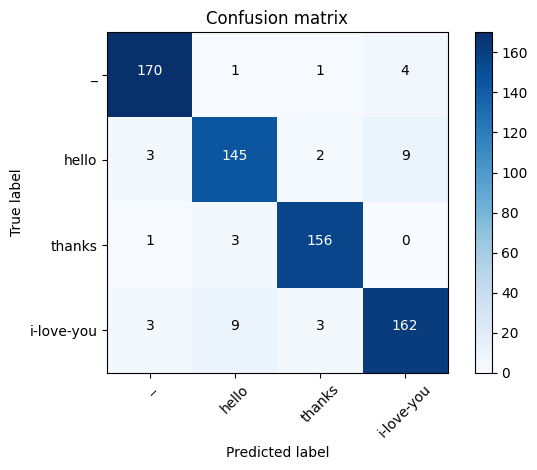

In [24]:
# plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(ACTIONS))
plt.xticks(tick_marks, ACTIONS, rotation=45)
plt.yticks(tick_marks, ACTIONS)

# add labels
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# compute and print accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy Score:", accuracy)

plt.show()

#### Saving the model

In [33]:
def get_next_filename(directory, base_name, extension):
    # list all files in the directory
    files = os.listdir(directory)

    # filter files that start with the base_name and end with the extension
    versions = [f for f in files if f.startswith(base_name) and f.endswith(extension)]

    # if the models directory is empty, then use the
    # default start version (001)
    if not versions and base_name == "singa_slr_v_":
        return f"{base_name}001.{extension}"

    # if the fiven basename is different than the actual basename
    # then save the model with given name
    if not base_name == "singa_slr_v_":
        return f"{base_name}.{extension}"

    # extract version numbers from filenames
    versions = [file.split("_")[-1] for file in versions]

    # convert version numbers to tuples of integers for comparison
    versions_int = [int(v.split(".")[0]) for v in versions]

    next_version = max(versions_int) + 1

    # format the next number with leading zeros to maintain the same length
    next_filename = f"{base_name}{next_version:03d}.{extension}"

    return next_filename


def save_as_tflite(_model, model_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(_model)

    # See issue here:
    # - https://github.com/tensorflow/tensorflow/issues/26869
    # - https://github.com/tensorflow/tensorflow/issues/26869#issuecomment-474984631
    # - https://github.com/tensorflow/tensorflow/issues/61662
    # - https://stackoverflow.com/a/67252118/14182545
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
        tf.lite.OpsSet.SELECT_TF_OPS,  # enable TensorFlow ops.
    ]

    tflite_model = converter.convert()

    with open(model_path, "wb") as f:
        f.write(tflite_model)

    f.close()


def save_as_keras(_model, model_path):
    _model.save(model_path)


def save_model(_model, extension="keras", base_name="singa_slr_v_"):
    model_dir = "../storage/models/" + extension

    next_filename = get_next_filename(model_dir, base_name, extension)
    model_path = os.path.join(model_dir, next_filename)

    match extension:
        case "tflite":
            save_as_tflite(_model, model_path)
            print(f"saved as tflite at {model_path}")

        case "keras":
            save_as_keras(_model, model_path)
            print(f"saved as keras at {model_path}")

In [34]:
save_model(model)

saved as keras at ../storage/models/keras\signa_slr_v_002.keras


In [ ]:
save_model(model, extension="tflite")